In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])    # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])    # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [7]:
# same optimization as last time
max_steps = 200000
batch_size = 32
context = torch.zeros((batch_size, block_size), dtype=torch.long)

lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # apply activation function
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break;

      0/ 200000: 3.3069


In [8]:
h.shape

torch.Size([32, 200])

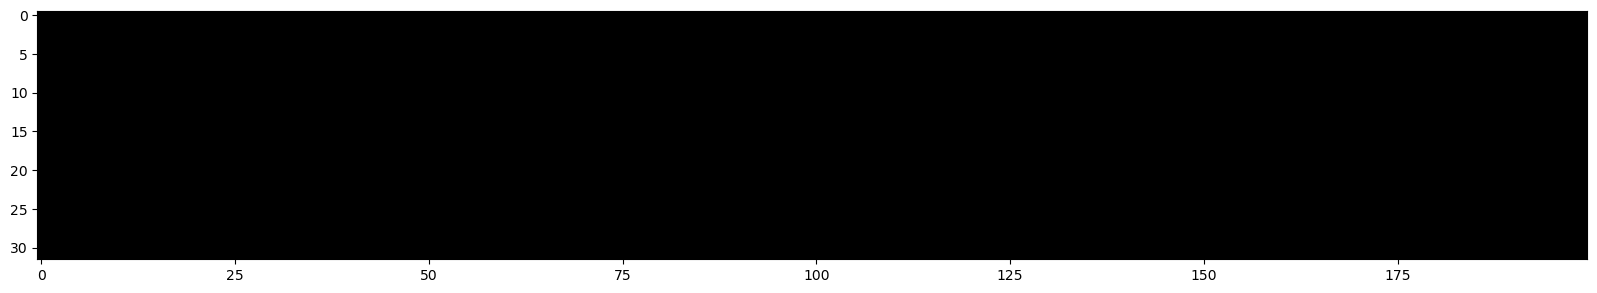

In [9]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

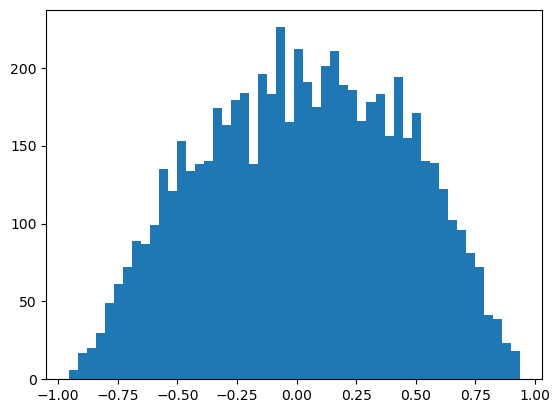

In [10]:
plt.hist(h.view(-1).tolist(), 50);

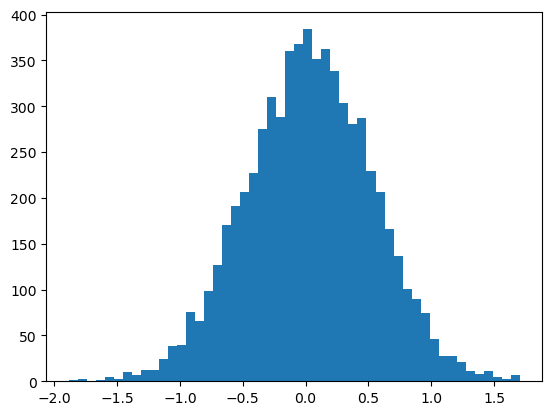

In [11]:
    plt.hist(hpreact.view(-1).tolist(), 50);

In [12]:
logits

tensor([[-0.0405,  0.1421, -0.0283,  0.0199,  0.0547, -0.0121, -0.0171,  0.0049,
          0.0016,  0.0383,  0.1011, -0.0390,  0.0050, -0.1152, -0.0352,  0.0168,
         -0.0065, -0.0920, -0.1353, -0.0063,  0.0800,  0.0880,  0.0685, -0.0652,
         -0.0892,  0.0727,  0.0656],
        [ 0.0591,  0.0051, -0.0254,  0.0440,  0.0166, -0.0381, -0.0651,  0.0162,
          0.0578,  0.0437,  0.0065, -0.0641, -0.0038, -0.0043, -0.0750,  0.0611,
         -0.0220, -0.0129,  0.0880,  0.0272,  0.0293, -0.0073, -0.0097,  0.0147,
          0.0685, -0.0525,  0.0758],
        [ 0.0324,  0.0476,  0.0578,  0.0043,  0.0280, -0.0087,  0.0567,  0.0634,
          0.0418,  0.1136,  0.0794,  0.0097,  0.0133, -0.0511,  0.0850,  0.1547,
         -0.0565,  0.0806,  0.1011, -0.0888,  0.0081,  0.0144, -0.0258, -0.1157,
          0.0620,  0.0352,  0.0103],
        [-0.0242,  0.0697,  0.0344,  0.0655, -0.0250, -0.0103, -0.0040,  0.0308,
         -0.0229, -0.0652,  0.0579,  0.0670,  0.0014, -0.0822, -0.0901,  0.0313

In [13]:
# 4 dimmensional example of the issue
logits = torch.tensor([-3.0,5.0,0.0,2.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()

probs, loss

(tensor([3.1741e-04, 9.4620e-01, 6.3754e-03, 4.7108e-02]), tensor(5.0553))

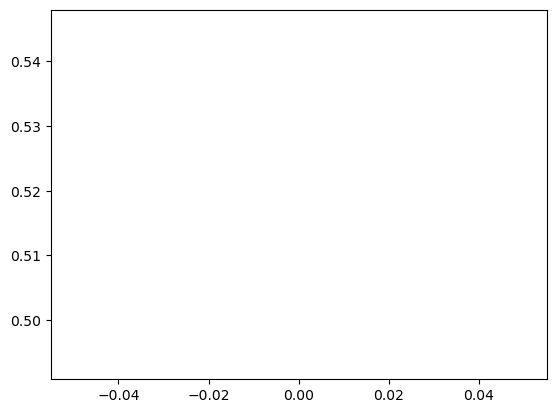

In [14]:
plt.plot(lossi)

In [15]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.2670235633850098
val 3.267206907272339


In [16]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[context]  # (batch_size, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

erbuagmyazzszevvndhfyaloqetvrsjejdrljg.
ozcjedgeliihsmpqppalekeixvqnpxarqeptzcmhvqrpcn.
szdbvrgxhgmjest.
jcjrwjkjqqxntpucfkubzmgvdtrxyqqufzehg.
kmejqvskkydmzhjl.
cakyybsufpzbjhlvjurenjcrtvwsvevoecmpfhdxrfqyxoeobhggptixjsfcueywhkhmrjolvii.
qiif.
wvpkxwvlla.
ortabfsztjndgoikvsblitgfkxvbssivpu.
meewrkepxcmvy.
xavttudkjgczekhgcgtipvtudt.
iwbddihzvorlq.
cjakepxfgniagcrpppfmiipzjgvonxet.
jydnblkskzporygnogsvmwosfzybsyknvmjcxtkncjbmu.
jtew.
aow.
copmplxkkdcqbcep.
ccdfivsnipimhtewmos.
gouwzlrurdckappomtcokwxtnbnzkdphfam.
xcojfffuncxzhosy.
